### 0. Imports and requirements

* В данном соревновании мы имеем дело с последовательностями, один из интуитивных способов работы с ними - использование рекуррентных сетей. Данный бейзлайн посвящен тому, чтобы показать, как можно строить хорошие решения без использования сложного и трудоемкого feature engineering-а (чтобы эффективно решать ту же задачу с высоким качеством с помощью бустингов нужно несколько тысяч признаков), благодаря рекуррентным сетям. В этом ноутбуке мы построим решение с использованием фреймфорка `torch`. Для комфортной работы Вам понадобится машина с `GPU` (хватит ресурсов `google colab` или `kaggle`).

In [1]:
%load_ext autoreload
%autoreload 2

import plotly
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image, display
import os
import pandas as pd
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
pd.set_option('display.max_columns', None)

# добавим корневую папку, в ней лежат все необходимые полезные функции для обработки данных
sys.path.append('../../')
sys.path.append('../')

### 1. Data Preprocessing

In [2]:
# dir_path = "../../../Datasets/AlfaBattle2.0/data_for_competition/"
# TRAIN_TRANSACTIONS_PATH = dir_path+'train_transactions_contest/'
# TEST_TRANSACTIONS_PATH = dir_path+'test_transactions_contest/'

# TRAIN_TARGET_PATH = dir_path+'train_target.csv'

In [3]:
TRAIN_TRANSACTIONS_PATH = '../../../train_transactions_contest/'
TEST_TRANSACTIONS_PATH = '../../../test_transactions_contest/'

TRAIN_TARGET_PATH = '../../../train_target.csv'

In [4]:
target_frame = pd.read_csv(TRAIN_TARGET_PATH)
target_frame.head()

,app_id,product,flag
0,0,3,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0


* Как и в случае с бустингами, мы не можем поместить всю выборку в память, в виду, например, ограниченных ресурсов. Для итеративного чтения данных нам потребуется функция `utils.read_parquet_dataset_from_local`, которая читает N частей датасета за раз в память.


* Нейронные сети требуют отделнього внимания к тому, как будут поданы и обработаны данные. Важные моменты, на которые требуется обратить внимание:
    * Использование рекуррентных сетей подразумевает работу на уровне последовательностей, где одна последовательность - все исторические транзакции клиента. Чтобы преобразовать `pd.DataFrame` с транзакциями клиентов в табличном виде к последовательностям, мы подготовили функцию `dataset_preprocessing_utils.transform_transactions_to_sequences`, она делает необходимые манипуляции и возвращает фрейм с двумя колонками: `app_id` и `sequences`. Колонка `sequence` представляет из себя массив массивов длины `len(features)`, где каждый вложенный массив - значения одного конкретного признака во всех транзакциях клиента. 
    
    * каждый клиент имеет различную по длине историю транзакций. При этом обучение сетей происходит батчами, что требует делать паддинги в последовательностях. Довольно неэффективно делать паддинг внутри батча на последовательностях случайной длины (довольно часто будем делать большой и бесполезный паддинг). Гораздо лучше использовать технику `sequence_bucketing` (о ней рассказано в образовательном ролике к данному бейзлайну). Для этого мы предоставляем функцию `dataset_preprocessing_utils.create_padded_buckets`. Один из аргументов в данную функцию - `bucket_info` - словарь, где для конкретной длины последовательности указано до какой длины нужно делать паддинг. Мы предоставялем для старта простой вид разбиения на 100 бакетов и файл где лежит отображение каждой длины в падднг (файл `buckets_info.pkl`).
    
    * Такие признаки, как [`amnt`, `days_before`, `hour_diff`] по своей природе не являются категориальными. Вы в праве самостоятельно выбирать способ работы с ними (модифицируя функции бейзлайна или адаптируя под себя). В рамках бейзлайна мы предлагаем интерпретировать каждую не категориальную фичу как категориальную. Для этого нужно подготовить bin-ы для каждой фичи. Мы предлагаем простой способ разбиения по бинам.

In [5]:
from utils import read_parquet_dataset_from_local
from dataset_preprocessing_utils import transform_transactions_to_sequences, create_padded_buckets

In [6]:
import pickle

with open('../constants/buckets_info.pkl', 'rb') as f:
    mapping_seq_len_to_padded_len = pickle.load(f)
    
with open('../constants/dense_features_buckets.pkl', 'rb') as f:
    dense_features_buckets = pickle.load(f)

* Функция `create_buckets_from_transactions` ниже реализует следующий набор действий:
    * Читает `num_parts_to_preprocess_at_once` частей датасета в память
    * Преобразует вещественные и численные признаки к категориальным (используя `np.digitize` и подготовленные бины)
    * Формирует фрейм с транзакциями в виде последовательностей с помощью `transform_transactions_to_sequences`.
    * Если указан `frame_with_ids`, то использует `app_id` из `frame_with_ids` - актуально, чтобы выделить валидационную выборку.
    * Реализует технику `sequence_bucketing` и сохраняет словарь обработанных последовательностей в `.pkl` файл

In [7]:
def create_buckets_from_transactions(path_to_dataset, save_to_path, frame_with_ids = None, 
                                     num_parts_to_preprocess_at_once: int = 1, 
                                     num_parts_total=50, has_target=False):
    block = 0
    for step in tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once), 
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, 
                                                             num_parts_to_preprocess_at_once, 
                                                             verbose=True)
        for dense_col in ['amnt', 'days_before', 'hour_diff']:
            transactions_frame[dense_col] = np.digitize(transactions_frame[dense_col], bins=dense_features_buckets[dense_col])
            
        seq = transform_transactions_to_sequences(transactions_frame)
        seq['sequence_length'] = seq.sequences.apply(lambda x: len(x[1]))
        
        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on='app_id')

        block_as_str = str(block)
        if len(block_as_str) == 1:
            block_as_str = '00' + block_as_str
        else:
            block_as_str = '0' + block_as_str
            
        processed_fragment =  create_padded_buckets(seq, mapping_seq_len_to_padded_len, has_target=has_target, 
                                                    save_to_file_path=os.path.join(save_to_path, 
                                                                                   f'processed_chunk_{block_as_str}.pkl'))
        block += 1

* Разобьем имеющиеся данные на `train` и `val` части. Воспользуемся самым простым способом - для валидации используем 10% случайных данных

In [8]:
train, val = train_test_split(target_frame, random_state=42, test_size=0.1)
train.shape, val.shape

((867429, 3), (96382, 3))

save val buckets

In [9]:
# ! rm -r ../../../val_buckets
# ! mkdir ../../../val_buckets

In [10]:
# create_buckets_from_transactions(TRAIN_TRANSACTIONS_PATH, 
#                                 save_to_path='../../../val_buckets',
#                                 frame_with_ids=val, num_parts_to_preprocess_at_once=1, num_parts_total=50, has_target=True)

In [11]:
path_to_dataset = '../../../val_buckets'
dir_with_datasets = os.listdir(path_to_dataset)
dataset_val = sorted([os.path.join(path_to_dataset, x) for x in dir_with_datasets])
dataset_val

['../../../val_buckets/processed_chunk_000.pkl',
 '../../../val_buckets/processed_chunk_001.pkl',
 '../../../val_buckets/processed_chunk_002.pkl',
 '../../../val_buckets/processed_chunk_003.pkl',
 '../../../val_buckets/processed_chunk_004.pkl',
 '../../../val_buckets/processed_chunk_005.pkl',
 '../../../val_buckets/processed_chunk_006.pkl',
 '../../../val_buckets/processed_chunk_007.pkl',
 '../../../val_buckets/processed_chunk_008.pkl',
 '../../../val_buckets/processed_chunk_009.pkl',
 '../../../val_buckets/processed_chunk_010.pkl',
 '../../../val_buckets/processed_chunk_011.pkl',
 '../../../val_buckets/processed_chunk_012.pkl',
 '../../../val_buckets/processed_chunk_013.pkl',
 '../../../val_buckets/processed_chunk_014.pkl',
 '../../../val_buckets/processed_chunk_015.pkl',
 '../../../val_buckets/processed_chunk_016.pkl',
 '../../../val_buckets/processed_chunk_017.pkl',
 '../../../val_buckets/processed_chunk_018.pkl',
 '../../../val_buckets/processed_chunk_019.pkl',
 '../../../val_bucke

save train buckets

In [12]:
# ! rm -r ../../../train_buckets
# ! mkdir ../../../train_buckets

In [13]:
# create_buckets_from_transactions(TRAIN_TRANSACTIONS_PATH, 
#                                 save_to_path='../../../train_buckets',
#                                 frame_with_ids=train, num_parts_to_preprocess_at_once=1, num_parts_total=50, has_target=True)

In [14]:
path_to_dataset = '../../../train_buckets'
dir_with_datasets = os.listdir(path_to_dataset)
dataset_train = sorted([os.path.join(path_to_dataset, x) for x in dir_with_datasets])
dataset_train

['../../../train_buckets/processed_chunk_000.pkl',
 '../../../train_buckets/processed_chunk_001.pkl',
 '../../../train_buckets/processed_chunk_002.pkl',
 '../../../train_buckets/processed_chunk_003.pkl',
 '../../../train_buckets/processed_chunk_004.pkl',
 '../../../train_buckets/processed_chunk_005.pkl',
 '../../../train_buckets/processed_chunk_006.pkl',
 '../../../train_buckets/processed_chunk_007.pkl',
 '../../../train_buckets/processed_chunk_008.pkl',
 '../../../train_buckets/processed_chunk_009.pkl',
 '../../../train_buckets/processed_chunk_010.pkl',
 '../../../train_buckets/processed_chunk_011.pkl',
 '../../../train_buckets/processed_chunk_012.pkl',
 '../../../train_buckets/processed_chunk_013.pkl',
 '../../../train_buckets/processed_chunk_014.pkl',
 '../../../train_buckets/processed_chunk_015.pkl',
 '../../../train_buckets/processed_chunk_016.pkl',
 '../../../train_buckets/processed_chunk_017.pkl',
 '../../../train_buckets/processed_chunk_018.pkl',
 '../../../train_buckets/proces

### 2. Modeling

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


* Для создания модели будем использовать фреймворк `torch`. В нем есть все, чтобы писать произвольные сложные архитектуры и быстро эксперементировать. Для того, чтобы мониторить и логировать весь процесс во время обучения сетей, рекомендуется использовать надстройки над данным фреймворков, например, `lightning`.

* В бейзлайне мы предлагаем базовые компоненты, чтобы можно было обучать нейронную сеть и отслеживать ее качество. Для этого вам предоставлены следующие функции:
    * `data_generators.batches_generator` - функция-генератор, итеративно возвращает батчи, поддерживает батчи для `tensorflow.keras` и `torch.nn.module` моделей. В зависимости от флага `is_train` может быть использована для генерации батчей на train/val/test стадию.
    * функция `pytorch_training.train_epoch` - обучает модель одну эпоху.
    * функция `pytorch_training.eval_model` - проверяет качество модели на отложенной выборке и возвращает roc_auc_score.
    * функция `pytorch_training.inference` - делает предикты на новых данных и готовит фрейм для проверяющей системы.
    * класс `training_aux.EarlyStopping` - реализует early_stopping, сохраняя лучшую модель. Пример использования приведен ниже.

In [16]:
from data_generators import batches_generator, transaction_features
from pytorch_training import train_epoch, eval_model, inference
from training_aux import EarlyStopping

* Все признаки в нашей модели будут категориальными. Для их представления в модели используем категориальные эмбеддинги. Для этого нужно каждому категориальному признаку задать размерность латентного пространства. Используем [формулу](https://forums.fast.ai/t/size-of-embedding-for-categorical-variables/42608) из библиотеки `fast.ai`. Все отображения хранятся в файле `embedding_projections.pkl`

In [17]:
with open('../constants/embedding_projections.pkl', 'rb') as f:
    embedding_projections = pickle.load(f)
embedding_projections

{'currency': (11, 6),
 'operation_kind': (7, 5),
 'card_type': (175, 29),
 'operation_type': (22, 9),
 'operation_type_group': (4, 3),
 'ecommerce_flag': (3, 3),
 'payment_system': (7, 5),
 'income_flag': (3, 3),
 'mcc': (108, 22),
 'country': (24, 9),
 'city': (163, 28),
 'mcc_category': (28, 10),
 'day_of_week': (7, 5),
 'hour': (24, 9),
 'weekofyear': (53, 15),
 'amnt': (10, 6),
 'days_before': (23, 9),
 'hour_diff': (10, 6),
 'product': (5, 4)}

In [18]:
transaction_features

['currency',
 'operation_kind',
 'card_type',
 'operation_type',
 'operation_type_group',
 'ecommerce_flag',
 'payment_system',
 'income_flag',
 'mcc',
 'country',
 'city',
 'mcc_category',
 'day_of_week',
 'hour',
 'weekofyear',
 'amnt',
 'days_before',
 'hour_diff']

* Реализуем модель. Все входные признаки представим в виде эмбеддингов, сконкатенируем, чтобы получить векторное представление транзакции. Подадим последовательности в `GRU` рекуррентную сеть. Используем последнее скрытое состояние в качестве выхода сети. Представим признак `product` в виде отдельного эмбеддинга. Сконкатенируем его с выходом сети. На основе такого входа построим небольшой `MLP`, выступающий классификатором для целевой задачи. Используем градиентный спуск, чтобы решить оптимизационную задачу. 

In [19]:
class TransactionsRnn(nn.Module):
    def __init__(self, transactions_cat_features, embedding_projections, product_col_name='product', rnn_units=128, top_classifier_units=32):
        super(TransactionsRnn, self).__init__()
        self._transaction_cat_embeddings = nn.ModuleList([self._create_embedding_projection(*embedding_projections[feature]) 
                                                          for feature in transactions_cat_features])
                
        self._product_embedding = self._create_embedding_projection(*embedding_projections[product_col_name], padding_idx=None)
        
        self._gru = nn.GRU(input_size=sum([embedding_projections[x][1] for x in transactions_cat_features]),
                             hidden_size=rnn_units, batch_first=True, bidirectional=False)
        
        self._hidden_size = rnn_units
                
        self._top_classifier = nn.Linear(in_features=rnn_units+embedding_projections[product_col_name][1], 
                                         out_features=top_classifier_units)
        self._intermediate_activation = nn.ReLU()
        
        self._head = nn.Linear(in_features=top_classifier_units, out_features=1)
    
    def forward(self, transactions_cat_features, product_feature):
        batch_size = product_feature.shape[0]
        
        embeddings = [embedding(transactions_cat_features[i]) for i, embedding in enumerate(self._transaction_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1)
        
        _, last_hidden = self._gru(concated_embeddings)
        last_hidden = torch.reshape(last_hidden.permute(1, 2, 0), shape=(batch_size, self._hidden_size))
        
        product_embed = self._product_embedding(product_feature)
        
        intermediate_concat = torch.cat([last_hidden, product_embed], dim=-1)
                
        classification_hidden = self._top_classifier(intermediate_concat)
        activation = self._intermediate_activation(classification_hidden)
        
        logit = self._head(activation)
        
        return logit
    
    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality+add_missing, embedding_dim=embed_size, padding_idx=padding_idx)


### 3. Training

In [20]:
# for

In [21]:
! mkdir ../../rnn_baseline/checkpoints/

mkdir: cannot create directory ‘../../rnn_baseline/checkpoints/’: File exists


In [22]:
# ! rm -r ../../rnn_baseline/checkpoints/pytorch_baseline
# ! mkdir ../../rnn_baseline/checkpoints/pytorch_baseline

* Для того, чтобы детектировать переобучение используем EarlyStopping.

In [23]:
path_to_checkpoints = '../../rnn_baseline/checkpoints/pytorch_baseline/'
es = EarlyStopping(patience=3, mode='max', verbose=True, 
                   save_path=os.path.join(path_to_checkpoints, 'best_checkpoint.pt'), 
                   metric_name='ROC-AUC', save_format='torch')

In [24]:
num_epochs = 3#15
# train_batch_size = 128
# val_batch_szie = 128
train_batch_size = val_batch_szie = 128

In [25]:
# val_batch_szie

In [26]:
embedding_projections

{'currency': (11, 6),
 'operation_kind': (7, 5),
 'card_type': (175, 29),
 'operation_type': (22, 9),
 'operation_type_group': (4, 3),
 'ecommerce_flag': (3, 3),
 'payment_system': (7, 5),
 'income_flag': (3, 3),
 'mcc': (108, 22),
 'country': (24, 9),
 'city': (163, 28),
 'mcc_category': (28, 10),
 'day_of_week': (7, 5),
 'hour': (24, 9),
 'weekofyear': (53, 15),
 'amnt': (10, 6),
 'days_before': (23, 9),
 'hour_diff': (10, 6),
 'product': (5, 4)}

In [27]:
# for

In [28]:
model = TransactionsRnn(transaction_features, embedding_projections, rnn_units=4, top_classifier_units=4 ).to(device)

In [29]:
device

device(type='cpu')

In [30]:
# model

In [31]:
optimizer = torch.optim.Adam(lr=1e-3, params=model.parameters())

* Запустим цикл обучения, каждую эпоху будем логировать лосс, а так же roc-auc на валидации и на обучении. Будем сохрнаять веса после каждой эпохи, а так же лучшие с помощью early_stopping.

In [32]:
file_num_constarint = 2
dataset_val = dataset_val[:file_num_constarint]
dataset_train = dataset_train[:file_num_constarint]

In [33]:
train_metrics = []
val_metrics = []
num_epochs = 15

Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.533643).  Saving model ...


Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train roc-auc: 0.5150238612616029, Val roc-auc: 0.5336426357733176


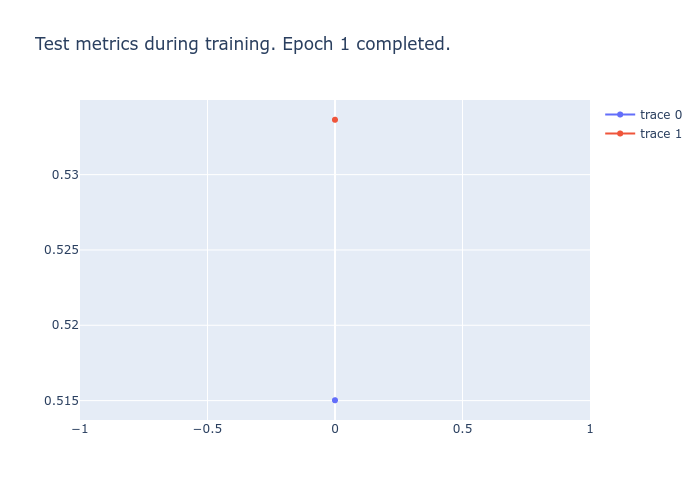

Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.533643 --> 0.534790).  Saving model ...


Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train roc-auc: 0.5185214851997109, Val roc-auc: 0.5347900678866588


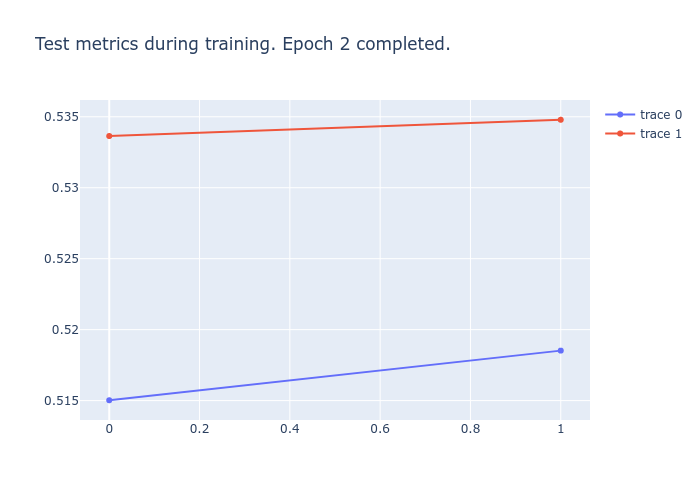

Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in Validation ROC-AUC. Current: 0.534337. Current best: 0.534790
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train roc-auc: 0.5203377389480917, Val roc-auc: 0.53433718270366


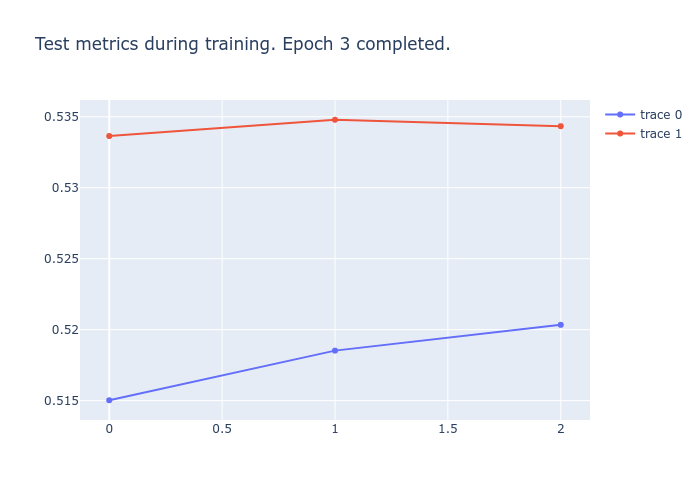

Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.534790 --> 0.535137).  Saving model ...


Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train roc-auc: 0.5233665245442899, Val roc-auc: 0.5351368801652893


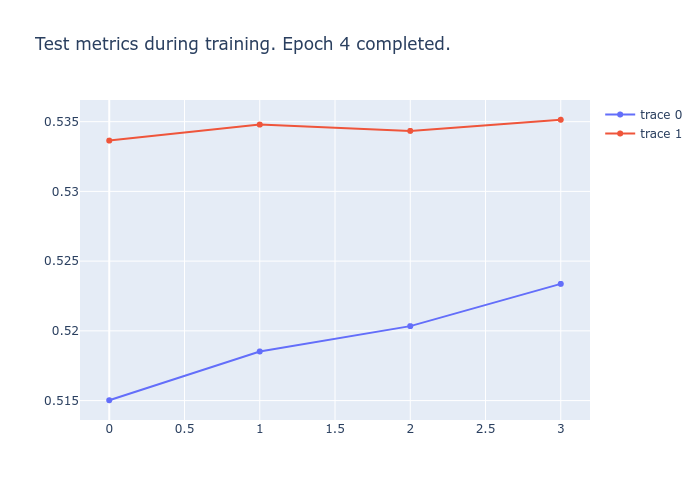

Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.535137 --> 0.536508).  Saving model ...


Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train roc-auc: 0.5273202052037187, Val roc-auc: 0.5365075265643447


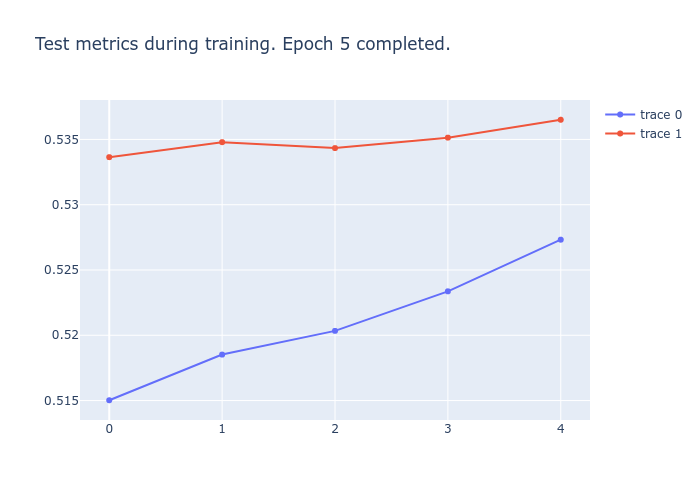

Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.536508 --> 0.538483).  Saving model ...


Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train roc-auc: 0.5332151042747644, Val roc-auc: 0.5384832497048406


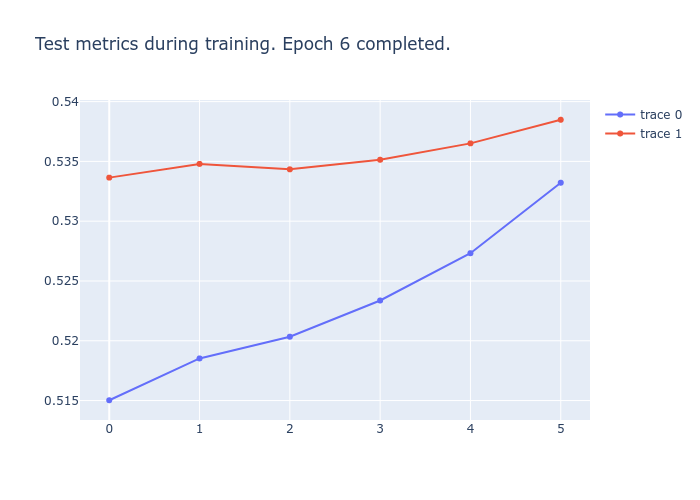

Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.538483 --> 0.543949).  Saving model ...


Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Train roc-auc: 0.5399623014879014, Val roc-auc: 0.5439492325855962


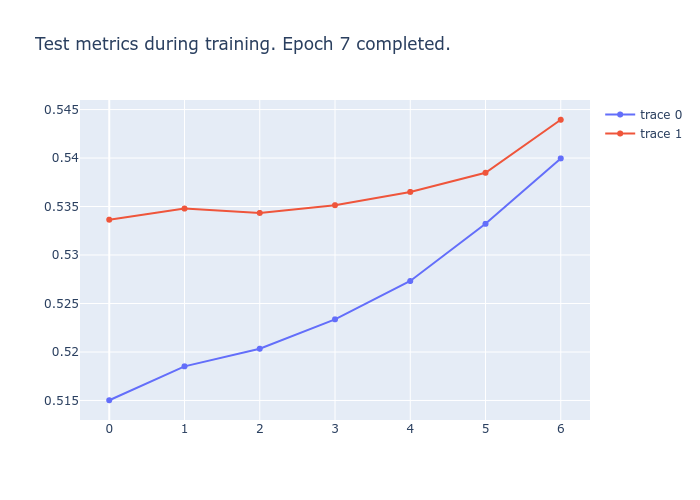

Starting epoch 8


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.543949 --> 0.549985).  Saving model ...


Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Epoch 8 completed. Train roc-auc: 0.5494874044565474, Val roc-auc: 0.5499852420306965


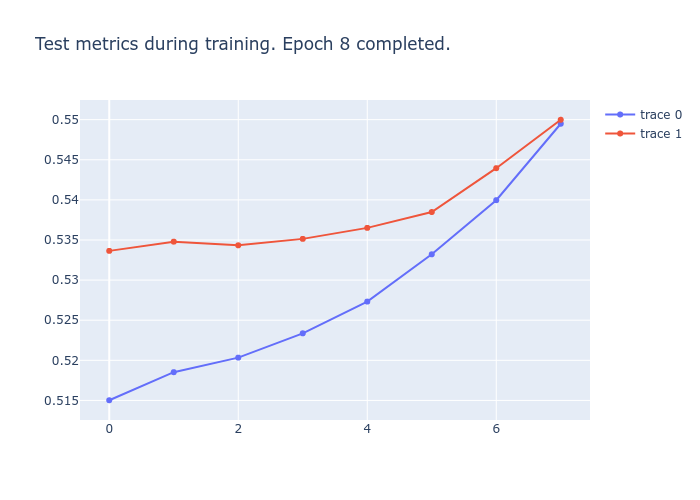

Starting epoch 9


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.549985 --> 0.553783).  Saving model ...


Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Epoch 9 completed. Train roc-auc: 0.5673596437159605, Val roc-auc: 0.5537826520070839


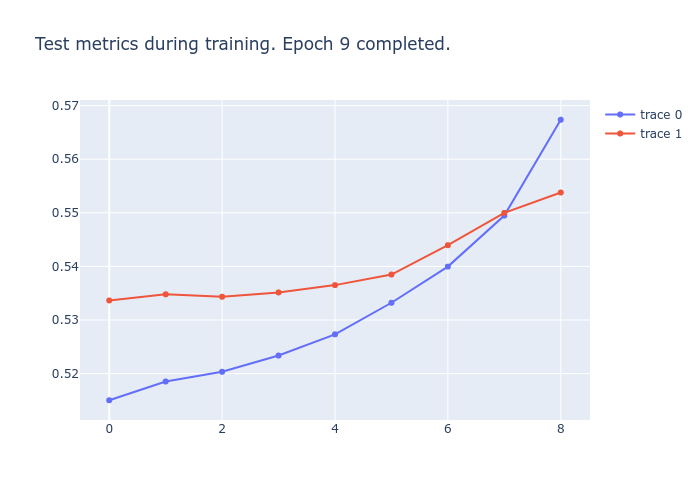

Starting epoch 10


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.553783 --> 0.659594).  Saving model ...


Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Epoch 10 completed. Train roc-auc: 0.6809876580761055, Val roc-auc: 0.659593602420307


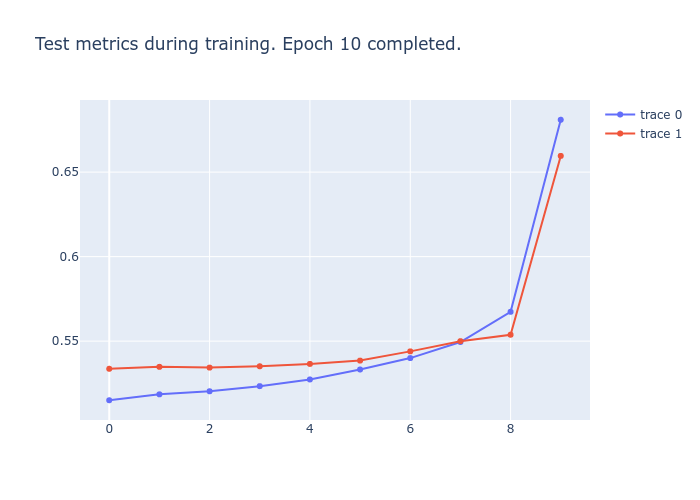

Starting epoch 11


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.659594 --> 0.664870).  Saving model ...


Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Epoch 11 completed. Train roc-auc: 0.686314037820178, Val roc-auc: 0.6648695764462811


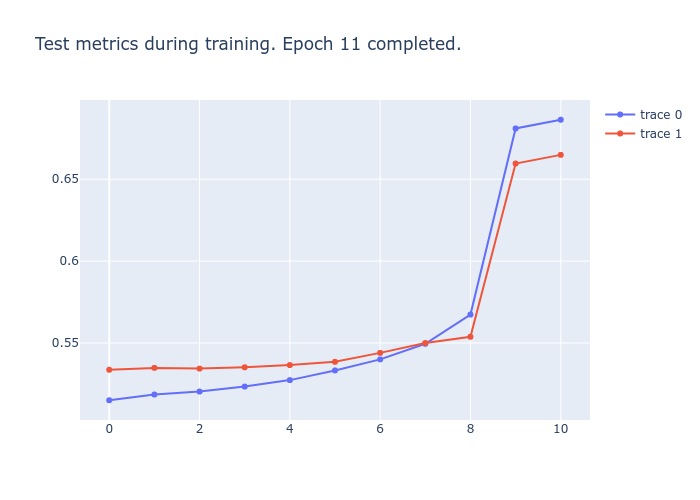

Starting epoch 12


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in Validation ROC-AUC. Current: 0.661414. Current best: 0.664870
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Epoch 12 completed. Train roc-auc: 0.7009780008516608, Val roc-auc: 0.6614143668831169


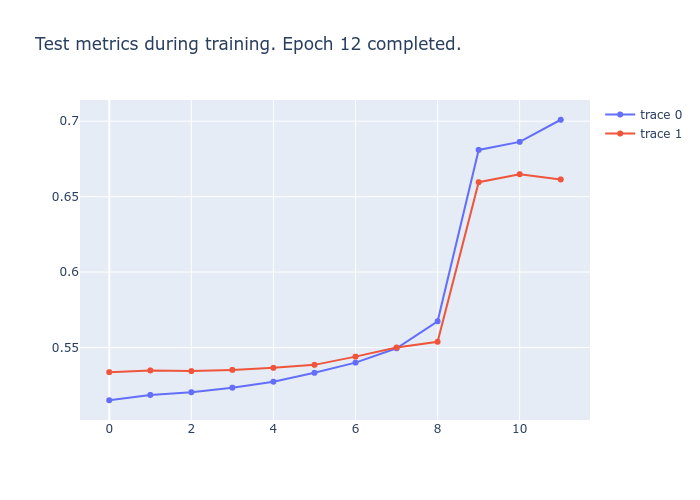

Starting epoch 13


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in Validation ROC-AUC. Current: 0.656820. Current best: 0.664870
EarlyStopping counter: 2 out of 3


Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Epoch 13 completed. Train roc-auc: 0.7036211460562383, Val roc-auc: 0.6568200265643448


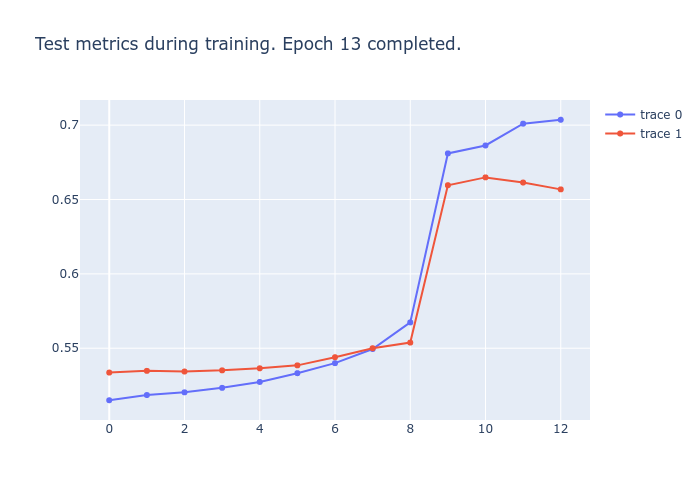

Starting epoch 14


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in Validation ROC-AUC. Current: 0.662173. Current best: 0.664870
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...


In [34]:
for epoch in range(num_epochs):
    print(f'Starting epoch {epoch+1}')
    train_epoch(model, optimizer, dataset_train, batch_size=train_batch_size,
                shuffle=True, print_loss_every_n_batches=25, device=device)

    val_roc_auc = eval_model(
        model, dataset_val, batch_size=val_batch_szie, device=device)
    es(val_roc_auc, model)

    if es.early_stop:
        print('Early stopping reached. Stop training...')
        break
    torch.save(model.state_dict(), os.path.join(
        path_to_checkpoints, f'epoch_{epoch+1}_val_{val_roc_auc:.3f}.pt'))

    train_roc_auc = eval_model(
        model, dataset_train, batch_size=val_batch_szie, device=device)
    train_metrics.append(train_roc_auc)
    val_roc_auc = eval_model(
        model, dataset_val, batch_size=val_batch_szie, device=device)
    val_metrics.append(val_roc_auc)
    print(f'Epoch {epoch+1} completed. Train roc-auc: {train_roc_auc}, Val roc-auc: {val_roc_auc}')
    fig = go.Figure()
    fig.update_layout(title_text=f"Test metrics during training. Epoch {epoch+1} completed.")
    fig.add_trace(go.Scatter(x=list(range(len(train_metrics))), y=train_metrics))
    fig.add_trace(go.Scatter(x=list(range(len(val_metrics))), y=val_metrics))
    display(Image(fig.to_image(format="png")))

### 4. Submission

* Все готово, чтобы сделать предсказания для тестовой выборки. Нужно только подготовить данные в том же формате, как и для train.

In [35]:
# ! rm -r ../../../test_buckets
# ! mkdir ../../../test_buckets

In [36]:
test_frame = pd.read_csv('../../../test_target_contest.csv')
test_frame.head()

,app_id,product
0,1063620,0
1,1063621,0
2,1063622,1
3,1063623,1
4,1063624,2


In [37]:
TRAIN_TRANSACTIONS_PATH

'../../../train_transactions_contest/'

In [38]:
TEST_TRANSACTIONS_PATH

'../../../test_transactions_contest/'

In [39]:
create_buckets_from_transactions(TEST_TRANSACTIONS_PATH, 
                                save_to_path='../../../test_buckets', frame_with_ids=test_frame, 
                                 num_parts_to_preprocess_at_once=10, num_parts_total=50, has_target=False)

Transforming transactions data:   0%|          | 0/5 [00:00<?, ?it/s]

Reading chunks:



Reading dataset with pandas: 0it [00:00, ?it/s]

Transforming transactions data:   0%|          | 0/5 [00:00<?, ?it/s]


ValueError: No objects to concatenate

In [ ]:
path_to_test_dataset = '../../../test_buckets/'
dir_with_test_datasets = os.listdir(path_to_test_dataset)
dataset_test = sorted([os.path.join(path_to_test_dataset, x) for x in dir_with_test_datasets])

dataset_test

* Отдельный вопрос, какую из построенных моделей использовать для того, чтобы делать предсказания на тест. Можно выбирать лучшую по early_stopping. В таком случае есть риск, что мы подгонимся под валидационную выборку, особенно если она не является очень репрезентативной, однако это самый базовый вариант (используем его). Можно делать разные версии ансамблирования, используя веса с разных эпох. Такой подход требует дополнительного кода (обязательно попробуйте его!). Наконец, можно выбирать такую модель, которая показывает хорошие результаты на валидации и в то же время, не слишком переучена под train выборку.

In [ ]:
! ls $path_to_checkpoints

In [ ]:
model.load_state_dict(torch.load(os.path.join(path_to_checkpoints, 'best_checkpoint.pt')))

In [ ]:
test_preds = inference(model, dataset_test, batch_size=128, device=device)

In [ ]:
test_preds.head()

In [ ]:
test_preds.to_csv('rnn_baseline_submission.csv', index=None) # ~ 0.750 на public test